In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

random_state = 1

In [2]:
skincare = pd.read_csv('skincare_prepared.csv', sep=",")
skincare

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100ml
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10ml
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15ml
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200ml
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500ml
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15ml
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30ml
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30ml
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50ml


In [3]:
skincare['contents'] = skincare['contents'].str.replace('ml', '')
skincare['contents'] = skincare['contents'].str.replace('g', '')
skincare
# Big assumption - treat ml and g as the same measurement because the viscosity for each product is unknown

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50


In [4]:
skincare['contents'] = skincare['contents'].astype(float)
skincare['price'] = skincare['price'].astype(float)
skincare

,product_name,brand,product_url,product_type,ingredients,price,contents
0,Acorelle Pure Harvest Body Perfume - 100ml,Acorelle,https://www.lookfantastic.com/acorelle-pure-ha...,Mist,"Alcohol, Aqua, Glycerin, Fragrance, Limonene, ...",10.0,100.0
1,Aesop Parsley Seed Anti-Oxidant Eye Cream 10ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Barbadensis Leaf Juice, Water, PEG-60 Alm...",63.0,10.0
2,Aesop Parsley Seed Anti-Oxidant Eye Serum 15ml,Aesop,https://www.lookfantastic.com/aesop-parsley-se...,Eye Care,"Aloe Babedensis Lead Juice, Water (Aqua), PEG ...",57.0,15.0
3,Aesop Amazing Face Cleanser 200ml,Aesop,https://www.lookfantastic.com/aesop-amazing-fa...,Cleanser,"Water, Cocamidopropyl Belaine, Sea Salt, Glyce...",35.0,200.0
4,Aesop Animal Body Wash 500ml,Aesop,https://www.lookfantastic.com/aesop-animal-bod...,Body Wash,"Water (Aqua), Sodium Laureth Sulfate, Propylen...",27.0,500.0
...,...,...,...,...,...,...,...
1130,Zelens Triple Action Advanced Eye Cream,Zelens,https://www.lookfantastic.com/zelens-triple-ac...,Eye Care,"Aqua (Water), Dimethicone, Cyclopentasiloxane,...",80.0,15.0
1131,Zelens Youth Concentrate Supreme Age-Defying S...,Zelens,https://www.lookfantastic.com/zelens-youth-con...,Serum,"Water (Aqua), Caprylic/Capric Triglyceride, Hy...",160.0,30.0
1132,Zelens Z Hyaluron Hyaluronic Acid Complex Seru...,Zelens,https://www.lookfantastic.com/zelens-z-hyaluro...,Serum,"Aqua (Water), Glycerin, Propanediol, Hydrolyze...",55.0,30.0
1133,Zelens PROVITAMIN D Fortifying Facial Mist 50ml,Zelens,https://www.lookfantastic.com/zelens-provitami...,Mist,"Aqua (Water), Propanediol, Glycerin, Polyglyce...",55.0,50.0


In [5]:
skincare['product_type'].unique() 

array(['Mist', 'Eye Care', 'Cleanser', 'Body Wash', 'Mask', 'Bath Salts',
       'Peel', 'Toner', 'Balm', 'Moisturiser', 'Bath Oil', 'Oil', 'Serum',
       'Exfoliator'], dtype=object)

In [6]:
print(skincare['price'].describe())

count    1135.000000
mean       23.963419
std        21.713618
min         1.950000
25%         9.950000
50%        18.900000
75%        31.250000
max       230.000000
Name: price, dtype: float64


In [7]:
print(type(skincare['price']))

<class 'pandas.core.series.Series'>


In [8]:
def price_to_class(x):
    if x <= 9.950000:
        x = 0
    elif (x > 9.950000) and (x <= 18.900000):
        x = 1
    elif (x > 18.900000) and (x <= 31.250000):
        x = 2
    elif x > 31.250000: 
        x = 3
    return x

In [9]:
skincare['price'] = skincare["price"].apply(price_to_class)
# convert the price to 1 for 'expensive' if over the 50 percentile, and to 0 for 'cheap' if under the 50 percentile
skincare['price'].value_counts()

0    286
3    284
2    283
1    282
Name: price, dtype: int64

In [10]:
y = np.array(skincare['price'])
y.shape
# prepare labels
y

array([1, 3, 3, ..., 3, 3, 3], dtype=int64)

In [11]:
def tokenizer(x) -> list: 
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace("\xa0", " ")
    x = x.replace(".", ",")
    x = x.replace(" & ", ", ")
    x = re.split(', ', x)
#     for item in x: 
#         if (item == "aqua") or (item == "water aqua") or (item == "aqua water") or (item == "water/aqua") or (item == "aqua / water") or (item = "aqua/water/eau") or (item == "water\\aqua\\eau ") or (item == "water aqua/eau") or (item == "aqua/water purified water"):
#             item = "water"
    
    return x

In [12]:
ohe = OneHotEncoder()
vect = CountVectorizer(tokenizer=lambda x: tokenizer(x))
scaler = StandardScaler()

# Brand and Product Type - MULTICLASS - LOGISTIC REGRESSION 

In [13]:
X = skincare[['brand', 'product_type']]


# now only use brand and product type
# the rest of the process below is exactly the same as the previous experiment



X
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.4, random_state=random_state, stratify=y)

In [14]:
ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "brand"),
    remainder="passthrough")

In [15]:
from sklearn.linear_model import LogisticRegression

lr_ovr = LogisticRegression(random_state=random_state)
lrovr_pipe = make_pipeline(ct, lr_ovr)
lrovr_pipe.fit(X_train, y_train)
lrovr_predictions = lrovr_pipe.predict(X_test)
accuracy_score(y_test, lrovr_predictions)

0.6101321585903083

In [16]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tols = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
param_grid = {'logisticregression__C': Cs, 'logisticregression__solver':solvers, 'logisticregression__tol':tols}
lrovr_pipe = make_pipeline(ct, lr_ovr)
lrovr_gs = RandomizedSearchCV(estimator=lrovr_pipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
lrovr_gs = lrovr_gs.fit(X_train, y_train)
lrovr_gs.best_params_

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the

{'logisticregression__tol': 0.1,
 'logisticregression__solver': 'newton-cg',
 'logisticregression__C': 10}

In [17]:
best_lrovr = lrovr_gs.best_estimator_   # refitting done automatically
print(best_lrovr.score(X_test, y_test))
scores = cross_val_score(estimator=best_lrovr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

0.6497797356828194
[0.5942029  0.67647059 0.64705882 0.73529412 0.60294118 0.73529412
 0.63235294 0.57352941 0.64705882 0.61764706]
Accuracy = 0.64618500 +/- 0.05258931


# Multinomial classification

In [18]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=random_state)
lrmn_pipe = make_pipeline(ct, lr_mn)

lrmn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                                  'brand')])),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=1))])

In [19]:
lrmn_predictions = lrmn_pipe.predict(X_test)

In [20]:
accuracy_score(y_test, lrmn_predictions)

0.6101321585903083

In [21]:
confusion_matrix(y_test, lrmn_predictions)

array([[87, 26,  0,  1],
       [22, 59, 27,  5],
       [ 9, 19, 59, 26],
       [ 4, 10, 28, 72]], dtype=int64)

In [22]:
tols = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
param_grid = {'logisticregression__C': Cs, 'logisticregression__tol':tols}
lrmn_pipe = make_pipeline(ct, lr_mn)
lrmn_gs = RandomizedSearchCV(estimator=lrmn_pipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
lrmn_gs = lrmn_gs.fit(X_train, y_train)
lrmn_gs.best_params_

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

{'logisticregression__tol': 1, 'logisticregression__C': 10}

In [23]:
best_lrmn = lrmn_gs.best_estimator_   # refitting done automatically
best_lrmn.score(X_test, y_test)

0.6497797356828194

In [24]:
scores = cross_val_score(estimator=best_lrmn, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

[0.5942029  0.67647059 0.69117647 0.72058824 0.58823529 0.72058824
 0.63235294 0.58823529 0.64705882 0.58823529]
Accuracy = 0.64471441 +/- 0.05192325


# Brand and Product Type - MULTICLASS - DECISION TREE

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=random_state, criterion='entropy')
ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "brand"),
    remainder="passthrough")
dt_pipe = make_pipeline(ct, dt)
dt_pipe.fit(X_train, y_train)
dt_predictions = dt_pipe.predict(X_test)
accuracy_score(y_test, dt_predictions)

0.5814977973568282

In [26]:
confusion_matrix(y_test, dt_predictions)
# largest numbers in correct categories but still lots of misclassifications

array([[85, 26,  3,  0],
       [22, 66, 19,  6],
       [ 8, 23, 54, 28],
       [ 7, 11, 37, 59]], dtype=int64)

In [27]:
criterions = ['gini', 'entropy']
max_depths = [None, 10, 100, 1000, 10000]
param_grid = {'decisiontreeclassifier__min_samples_leaf': np.arange(1,50), 
              'decisiontreeclassifier__max_depth': max_depths, 
              'decisiontreeclassifier__criterion':criterions}

dt_gs = RandomizedSearchCV(estimator=dt_pipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
dt_gs = dt_gs.fit(X_train, y_train)
print(dt_gs.best_params_)
best_dt = dt_gs.best_estimator_   # refitting done automatically
print(best_dt.score(X_test, y_test))

{'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__max_depth': 10000, 'decisiontreeclassifier__criterion': 'gini'}
0.5616740088105727


In [28]:
scores = cross_val_score(estimator=best_dt, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)

[0.55072464 0.52941176 0.57352941 0.52941176 0.52941176 0.58823529
 0.5        0.42647059 0.58823529 0.5       ]


In [29]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.53154305 +/- 0.04647858


# Brand and Product Type  - MULTICLASS - KNN

In [30]:
# redefine the column transformer to scale the contents again

In [31]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=5)
ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "brand"), 
    remainder="passthrough")
knn_pipe = make_pipeline(ct, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                                  'brand')])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [32]:
knn_predictions = knn_pipe.predict(X_test)
accuracy_score(y_test, knn_predictions)

0.5066079295154186

In [33]:
confusion_matrix(y_test, knn_predictions)

array([[74, 30,  8,  2],
       [27, 66, 15,  5],
       [14, 47, 42, 10],
       [16, 26, 24, 48]], dtype=int64)

In [34]:
knn_pipe = make_pipeline(ct, knn)
param_grid = {'kneighborsclassifier__n_neighbors': np.arange(1,50), 
              'kneighborsclassifier__weights':['uniform', 'distance']}

knn_gs = RandomizedSearchCV(estimator=knn_pipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
knn_gs = knn_gs.fit(X_train, y_train)
print(knn_gs.best_params_)
best_knn = knn_gs.best_estimator_   # refitting done automatically
print(best_knn.score(X_test, y_test))

{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 14}
0.5704845814977973


In [35]:
scores = cross_val_score(estimator=best_knn, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)

[0.57971014 0.58823529 0.64705882 0.63235294 0.48529412 0.63235294
 0.60294118 0.44117647 0.57352941 0.51470588]


In [36]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.56973572 +/- 0.06485797


# Brand and Product Type  - MULTICLASS - SVM

## One-vs-rest classification

In [37]:
from sklearn.multiclass import OneVsRestClassifier

In [38]:
ovr_svm = OneVsRestClassifier(LinearSVC())
# use the one versus rest function from the multiclass module

In [39]:
ovr_svm_pipe = make_pipeline(ct, ovr_svm)

ovr_svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                                  'brand')])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LinearSVC()))])

In [40]:
ovr_svm_predictions = ovr_svm_pipe.predict(X_test)

In [41]:
accuracy_score(y_test, ovr_svm_predictions)

0.6387665198237885

In [42]:
confusion_matrix(y_test, ovr_svm_predictions)
# most are predicted well but there are tons of misclassifications

array([[91, 21,  1,  1],
       [26, 63, 20,  4],
       [ 8, 22, 52, 31],
       [ 1,  6, 23, 84]], dtype=int64)

In [43]:
ovr_svm_pipe.get_params()

# Not able to easily do gridsearch

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                    'brand')])),
  ('onevsrestclassifier', OneVsRestClassifier(estimator=LinearSVC()))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                  'brand')]),
 'onevsrestclassifier': OneVsRestClassifier(estimator=LinearSVC()),
 'columntransformer__

In [44]:
scores = cross_val_score(estimator=ovr_svm_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)

[0.56521739 0.63235294 0.61764706 0.64705882 0.60294118 0.67647059
 0.57352941 0.51470588 0.61764706 0.54411765]


In [45]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.59916880 +/- 0.04694893


## One-vs-one classification

In [46]:
from sklearn.multiclass import OneVsOneClassifier
# use the multiclass module again
ovo_svm = OneVsOneClassifier(LinearSVC())

ovo_svm_pipe = make_pipeline(ct, ovo_svm)

ovo_svm_pipe.fit(X_train, y_train)

ovo_svm_predictions = ovo_svm_pipe.predict(X_test)

In [84]:
accuracy_score(y_test, ovo_svm_predictions)
# get initial predictions

0.6674008810572687

In [83]:
ovo_svm_pipe.get_params()
# inspect parameters

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehotencoder', OneHotEncoder(),
                                    ['product_type']),
                                   ('countvectorizer',
                                    CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                    'brand')])),
  ('onevsoneclassifier', OneVsOneClassifier(estimator=LinearSVC()))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder', OneHotEncoder(),
                                  ['product_type']),
                                 ('countvectorizer',
                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                  'brand')]),
 'onevsoneclassifier': OneVsOneClassifier(estimator=LinearSVC()),
 'columntransformer__n_jo

In [48]:
scores = cross_val_score(estimator=ovo_svm_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)

[0.62318841 0.61764706 0.70588235 0.70588235 0.64705882 0.73529412
 0.66176471 0.5        0.66176471 0.57352941]


In [49]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

Accuracy = 0.64320119 +/- 0.06592216


# Brand and Product Type - MULTICLASS - VOTING CLASSIFIER

In [50]:
from sklearn.ensemble import VotingClassifier

lr = LogisticRegression(tol=1e-05, solver='saga', C=10, random_state=random_state)
dt = DecisionTreeClassifier(min_samples_leaf=2, max_depth= 10000, criterion="gini", random_state=random_state)
ovo_svm = OneVsOneClassifier(LinearSVC())
# voting classifier fitted on the best models


classifiers = [("Logistic Regression", lr),
              ("Decision Tree", dt),
              ("Support Vector Classifier", ovo_svm)]
vc = VotingClassifier(estimators = classifiers)

vc_pipe = make_pipeline(ct, vc)

In [51]:
vc_pipe.fit(X_train, y_train)
vc_predictions = vc_pipe.predict(X_test)
accuracy_score(y_test, vc_predictions)
# get the initial accuracy score

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.6475770925110133

In [52]:
scores = cross_val_score(estimator=vc_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)

[0.60869565 0.64705882 0.70588235 0.73529412 0.63235294 0.76470588
 0.63235294 0.52941176 0.66176471 0.57352941]


In [53]:
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))
# get the cross validation scores

Accuracy = 0.64910486 +/- 0.06812677


# Brand and Product Type - MULTICLASS - BAGGING CLASSIFIER

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier(min_samples_leaf=2, max_depth= 10000, criterion="gini", random_state=random_state)

bc = BaggingClassifier(base_estimator = dt, random_state=random_state, n_estimators = 300, n_jobs = -1)

ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, "brand"),
    remainder="passthrough")

bc_pipe = make_pipeline(ct, bc)
bc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['product_type']),
                                                 ('countvectorizer',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x000002A4E67AF0D0>),
                                                  'brand')])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10000,
                                                                         min_samples_leaf=2,
                                                                         random_state=1),
                                   n_estimators=300, n_jobs=-1,
                                   random_state=1))])

In [55]:
bc_predictions = bc_pipe.predict(X_test)
accuracy_score(y_test, bc_predictions)

0.579295154185022

In [57]:
accs = []
n_estimators_range = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for n_estimators in n_estimators_range: 
    bc = BaggingClassifier(base_estimator = dt, random_state=random_state, n_estimators = n_estimators, n_jobs = -1)
    ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, 'brand'), 
    remainder="passthrough")
    bc_pipe = make_pipeline(ct, bc)
    bc_pipe.fit(X_train, y_train)
    bc_pred = bc_pipe.predict(X_test)
    acc = accuracy_score(y_test, bc_pred)
    accs.append(acc)
    print(n_estimators, "Done with this number of estimators")

100 Done with this number of estimators
200 Done with this number of estimators
300 Done with this number of estimators
400 Done with this number of estimators
500 Done with this number of estimators
600 Done with this number of estimators
700 Done with this number of estimators
800 Done with this number of estimators
900 Done with this number of estimators
1000 Done with this number of estimators


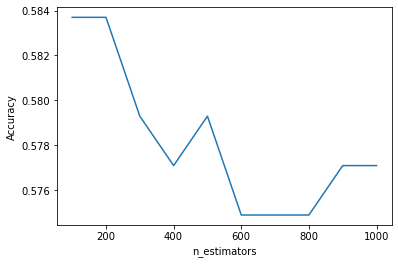

In [58]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(n_estimators_range, accs)
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.show()

In [60]:
bc = BaggingClassifier(base_estimator = dt, random_state=random_state, n_estimators = 100, n_jobs = -1)
# Switch to 100 - lowest complexity, best accuracy

ct = make_column_transformer(
    (ohe, ["product_type"]),
    (vect, 'brand'),
    remainder="passthrough")
bc_pipe = make_pipeline(ct, bc)

bc_pipe.fit(X_train, y_train)
bc_pred = bc_pipe.predict(X_test)
print(accuracy_score(y_test, bc_pred))


scores = cross_val_score(estimator=bc_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))

0.5837004405286343
[0.5942029  0.45588235 0.54411765 0.57352941 0.51470588 0.60294118
 0.51470588 0.42647059 0.57352941 0.48529412]
Accuracy = 0.52853794 +/- 0.05664643


# w/ BRAND - MULTICLASS - RANDOM FORESTS

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = random_state)

rf_pipe = make_pipeline(ct, rf)
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)
accuracy_score(y_test, rf_pred)

0.6167400881057269

In [62]:
criterions = ['gini', 'entropy']
max_depths = [None, 10, 100, 1000, 10000]
param_grid = {'randomforestclassifier__min_samples_leaf': np.arange(1,50), 
              'randomforestclassifier__max_depth': max_depths, 
              'randomforestclassifier__criterion':criterions}
rf = RandomForestClassifier(n_estimators = 1000, random_state = random_state)
rf_pipe = make_pipeline(ct, rf)

rf_gs = RandomizedSearchCV(estimator=rf_pipe, param_distributions=param_grid, random_state=random_state, scoring='accuracy', cv=10, refit=True)
rf_gs = rf_gs.fit(X_train, y_train)
print(rf_gs.best_params_)
best_rf = rf_gs.best_estimator_   # refitting done automatically
print(best_rf.score(X_test, y_test))
# get the accuracy score of the best performer

{'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 10000, 'randomforestclassifier__criterion': 'gini'}
0.5859030837004405


In [63]:
scores = cross_val_score(estimator=best_rf, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)
print('Accuracy = {:.8f} +/- {:.8f}'.format(np.mean(scores), np.std(scores)))
# report cross val score of best model 

[0.55072464 0.44117647 0.60294118 0.58823529 0.52941176 0.61764706
 0.5        0.42647059 0.51470588 0.51470588]
Accuracy = 0.52860188 +/- 0.06064640


# Learning Curve to Diagnose Possible Variance/Bias Problems: 

In [65]:
from sklearn.model_selection import learning_curve
# use the learning curve function

C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the

[0.93688525 0.90245902 0.87220708 0.84314928] [0.01040047 0.0115629  0.00839396 0.01042945] [0.4950341  0.59490622 0.6006607  0.61530264] [0.06803449 0.0739075  0.08086459 0.06104046]


C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Dora\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


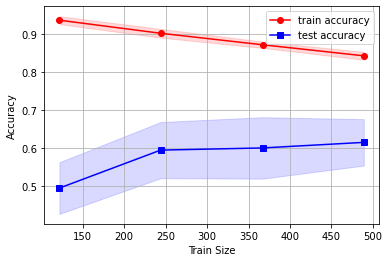

In [81]:
train_sizes, train_scores, test_scores = learning_curve(estimator=vc_pipe, 
                                                        X=X_train, 
                                                        y=y_train, 
                                                        cv=10, 
                                                        train_sizes=np.array([0.2, 0.4, 0.6, 0.8]))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean, train_std, test_mean, test_std)
plt.plot(train_sizes, train_mean, color='red', label="train accuracy", marker='o')
plt.fill_between(train_sizes,  train_mean+train_std, train_mean-train_std, alpha=0.15, color='red')
plt.plot(train_sizes, test_mean, color='blue', label="test accuracy",  marker='s')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='blue')
plt.xlabel("Train Size")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc="upper right")
plt.show()

# get a learning curve to see what the problem is - high variance!!!!
# giant gap between train and test accuracy
